#### Heap size error
- run this command line before run jupyter notebook on command line

export PYSPARK_SUBMIT_ARGS=' --driver-memory 16g --driver-cores 6 --executor-memory 16g --executor-cores 6 pyspark-shell'

In [1]:
# Configure MLflow Experiment
mlflow_experiment_id = 866112

# Including MLflow
import mlflow
import mlflow.spark
import os
print("MLflow Version: %s" % mlflow.__version__)

MLflow Version: 2.1.1


In [2]:
import pandas as pd
import numpy as np

### Source Data

In [3]:
#Data set is synthetic dataset is scaled down 1/4 of the original dataset and it is created just for Kaggle
data_urls = "https://media.githubusercontent.com/media/FelixQLe/Detect_Financial_Fraud_at_Scale_with_decision_Trees/main/Synthetic_Financial_datasets_log.csv"

In [4]:
fin_fraud_dataset = pd.read_csv(data_urls, delimiter=',', header = 0)

In [5]:
#large dataset takes longer to load, so i make a copy to reuse in case
fin_fraud_copy = fin_fraud_dataset.copy()

In [6]:
fin_fraud_copy.shape

(6362620, 11)

### Create SQL database using PySpark

In [7]:
#import pyspark
import pyspark
from pyspark import SparkContext, SparkConf
from pyspark.sql import SparkSession, SQLContext
print(f"PySpark Version : {pyspark.__version__}")

PySpark Version : 3.3.0


In [8]:
#Create a spark Context class
#sc = SparkContext.getOrCreate(SparkConf().setMaster('local[*]'))
# Create spark builder session
#Create a spark Context class
sc = SparkContext()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


23/02/07 20:29:52 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [9]:
## Create spark session
spark = SparkSession.builder.master('local[6]').\
                config('saprk.sql.shuffle.partitions', 200).\
                config('spark.sql.debug.maxToStringFields', '100').\
                config('spark.default.parallelism', 300).\
                appName("Python Spark Dataframes Financial Fruad").getOrCreate()

In [10]:
fin_fraud_copy.head(5)

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [11]:
#Loading data into Spark, take long
spark_df = spark.createDataFrame(fin_fraud_copy)

In [12]:
spark_df.printSchema()

root
 |-- step: long (nullable = true)
 |-- type: string (nullable = true)
 |-- amount: double (nullable = true)
 |-- nameOrig: string (nullable = true)
 |-- oldbalanceOrg: double (nullable = true)
 |-- newbalanceOrig: double (nullable = true)
 |-- nameDest: string (nullable = true)
 |-- oldbalanceDest: double (nullable = true)
 |-- newbalanceDest: double (nullable = true)
 |-- isFraud: long (nullable = true)
 |-- isFlaggedFraud: long (nullable = true)



In [13]:
spark_df.show()

23/02/07 20:33:14 WARN TaskSetManager: Stage 0 contains a task of very large size (64404 KiB). The maximum recommended task size is 1000 KiB.


23/02/07 20:33:19 WARN PythonRunner: Detected deadlock while completing task 0.0 in stage 0 (TID 0): Attempting to kill Python Worker


+----+--------+---------+-----------+-------------+--------------+-----------+--------------+--------------+-------+--------------+
|step|    type|   amount|   nameOrig|oldbalanceOrg|newbalanceOrig|   nameDest|oldbalanceDest|newbalanceDest|isFraud|isFlaggedFraud|
+----+--------+---------+-----------+-------------+--------------+-----------+--------------+--------------+-------+--------------+
|   1| PAYMENT|  9839.64|C1231006815|     170136.0|     160296.36|M1979787155|           0.0|           0.0|      0|             0|
|   1| PAYMENT|  1864.28|C1666544295|      21249.0|      19384.72|M2044282225|           0.0|           0.0|      0|             0|
|   1|TRANSFER|    181.0|C1305486145|        181.0|           0.0| C553264065|           0.0|           0.0|      1|             0|
|   1|CASH_OUT|    181.0| C840083671|        181.0|           0.0|  C38997010|       21182.0|           0.0|      1|             0|
|   1| PAYMENT| 11668.14|C2048537720|      41554.0|      29885.86|M123070170

In [14]:
#create table view fin_fraud_table, we can treat it as sql table
spark_df.createTempView("fin_fraud_table")

In [15]:
# Create df DataFrame which contains our simulated financial fraud detection dataset
original_fin_fraud_df = spark.sql("select step, type, amount, nameOrig, oldbalanceOrg, newbalanceOrig, nameDest, oldbalanceDest, newbalanceDest from fin_fraud_table")

In [16]:
original_fin_fraud_df.printSchema()

root
 |-- step: long (nullable = true)
 |-- type: string (nullable = true)
 |-- amount: double (nullable = true)
 |-- nameOrig: string (nullable = true)
 |-- oldbalanceOrg: double (nullable = true)
 |-- newbalanceOrig: double (nullable = true)
 |-- nameDest: string (nullable = true)
 |-- oldbalanceDest: double (nullable = true)
 |-- newbalanceDest: double (nullable = true)



In [17]:
# Review the schema of your data 
original_fin_fraud_df.show()

23/02/07 20:33:20 WARN TaskSetManager: Stage 1 contains a task of very large size (64404 KiB). The maximum recommended task size is 1000 KiB.


23/02/07 20:33:24 WARN PythonRunner: Detected deadlock while completing task 0.0 in stage 1 (TID 1): Attempting to kill Python Worker
+----+--------+---------+-----------+-------------+--------------+-----------+--------------+--------------+
|step|    type|   amount|   nameOrig|oldbalanceOrg|newbalanceOrig|   nameDest|oldbalanceDest|newbalanceDest|
+----+--------+---------+-----------+-------------+--------------+-----------+--------------+--------------+
|   1| PAYMENT|  9839.64|C1231006815|     170136.0|     160296.36|M1979787155|           0.0|           0.0|
|   1| PAYMENT|  1864.28|C1666544295|      21249.0|      19384.72|M2044282225|           0.0|           0.0|
|   1|TRANSFER|    181.0|C1305486145|        181.0|           0.0| C553264065|           0.0|           0.0|
|   1|CASH_OUT|    181.0| C840083671|        181.0|           0.0|  C38997010|       21182.0|           0.0|
|   1| PAYMENT| 11668.14|C2048537720|      41554.0|      29885.86|M1230701703|           0.0|          

In [18]:
#add column orgDiff and destDiff based on the difference between Originating and Destination
original_fin_fraud_df = original_fin_fraud_df.withColumn("orgDiff",
                            original_fin_fraud_df.newbalanceOrig - 
                                       original_fin_fraud_df.oldbalanceOrg).withColumn("destDiff",
                            original_fin_fraud_df.newbalanceDest - original_fin_fraud_df.oldbalanceDest)
    
#create temporary view
original_fin_fraud_df.createOrReplaceTempView("financials")

In [19]:
original_fin_fraud_df.printSchema()

root
 |-- step: long (nullable = true)
 |-- type: string (nullable = true)
 |-- amount: double (nullable = true)
 |-- nameOrig: string (nullable = true)
 |-- oldbalanceOrg: double (nullable = true)
 |-- newbalanceOrig: double (nullable = true)
 |-- nameDest: string (nullable = true)
 |-- oldbalanceDest: double (nullable = true)
 |-- newbalanceDest: double (nullable = true)
 |-- orgDiff: double (nullable = true)
 |-- destDiff: double (nullable = true)



In [20]:
#review the new table
original_fin_fraud_df.show()

23/02/07 20:33:24 WARN TaskSetManager: Stage 2 contains a task of very large size (64404 KiB). The maximum recommended task size is 1000 KiB.


23/02/07 20:33:28 WARN PythonRunner: Detected deadlock while completing task 0.0 in stage 2 (TID 2): Attempting to kill Python Worker
+----+--------+---------+-----------+-------------+--------------+-----------+--------------+--------------+-------------------+-------------------+
|step|    type|   amount|   nameOrig|oldbalanceOrg|newbalanceOrig|   nameDest|oldbalanceDest|newbalanceDest|            orgDiff|           destDiff|
+----+--------+---------+-----------+-------------+--------------+-----------+--------------+--------------+-------------------+-------------------+
|   1| PAYMENT|  9839.64|C1231006815|     170136.0|     160296.36|M1979787155|           0.0|           0.0| -9839.640000000014|                0.0|
|   1| PAYMENT|  1864.28|C1666544295|      21249.0|      19384.72|M2044282225|           0.0|           0.0|-1864.2799999999988|                0.0|
|   1|TRANSFER|    181.0|C1305486145|        181.0|           0.0| C553264065|           0.0|           0.0|             

## Exploring Data Analysis

### What are the type of transactions?

In [21]:
%load_ext sparksql_magic

%config SparkSql.limit=20

In [22]:
%%sparksql
select type, count(1) from financials group by type

23/02/07 20:33:30 WARN TaskSetManager: Stage 3 contains a task of very large size (64404 KiB). The maximum recommended task size is 1000 KiB.


type,count(1)
TRANSFER,532909
CASH_IN,1399284
CASH_OUT,2237500
PAYMENT,2151495
DEBIT,41432


##### plot the type of transactions

In [23]:
#collect type of transactions
type_transactions = 'select type, count(1) from financials group by type'
collected_data1 = spark.sql(type_transactions).collect()

23/02/07 20:33:41 WARN TaskSetManager: Stage 6 contains a task of very large size (64404 KiB). The maximum recommended task size is 1000 KiB.


In [24]:
collected_data1

[Row(type='TRANSFER', count(1)=532909),
 Row(type='CASH_IN', count(1)=1399284),
 Row(type='CASH_OUT', count(1)=2237500),
 Row(type='PAYMENT', count(1)=2151495),
 Row(type='DEBIT', count(1)=41432)]

In [25]:
#convert to dataframe for plotting
df_trans_type = pd.DataFrame(collected_data1)
df_trans_type.rename(columns={0:'transactions', 1:'trans_total'}, inplace=True)

In [26]:
df_trans_type

,transactions,trans_total
0,TRANSFER,532909
1,CASH_IN,1399284
2,CASH_OUT,2237500
3,PAYMENT,2151495
4,DEBIT,41432


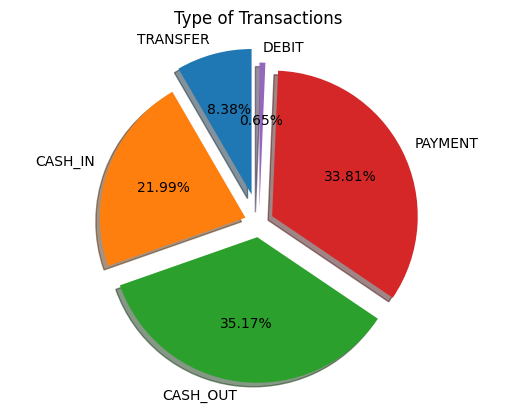

In [27]:
#plotting
import matplotlib.pyplot as plt
labels = df_trans_type.transactions
volume = df_trans_type.trans_total
explode = (0.2, 0.1, 0.1, 0.1, 0.1) # 5 volume to be exploded
#pie
plt.pie(volume, labels=labels, startangle=90,
        shadow=True, explode=explode, autopct='%1.2f%%')
#title
plt.title('Type of Transactions')
plt.axis('equal')
plt.show()

### How much money each type of transactions made(synthetically)?

In [28]:
%%sparksql
SELECT type, SUM(amount) FROM financials GROUP BY type

23/02/07 20:33:52 WARN TaskSetManager: Stage 9 contains a task of very large size (64404 KiB). The maximum recommended task size is 1000 KiB.


type,sum(amount)
TRANSFER,485291987263.16876
CASH_IN,236367391912.45996
CASH_OUT,394412995224.4904
PAYMENT,28093371138.37003
DEBIT,227199221.27999985


##### plot the the amount of money

In [29]:
#collect money data
total_money_each_type_trans = 'SELECT type, SUM(amount) FROM financials GROUP BY type'
collected_data2 = spark.sql(total_money_each_type_trans).collect()

23/02/07 20:33:59 WARN TaskSetManager: Stage 12 contains a task of very large size (64404 KiB). The maximum recommended task size is 1000 KiB.


In [30]:
pd.DataFrame(collected_data2)

,0,1
0,TRANSFER,4.852920e+11
1,CASH_IN,2.363674e+11
2,CASH_OUT,3.944130e+11
3,PAYMENT,2.809337e+10
4,DEBIT,2.271992e+08


In [31]:
from math import log, floor

def number_format(number):
    #function format number to B
    units = 'B'
    k = 1000000000.0
    #m = int(floor(log(number, k)))
    return '%.3f' % (number / k)

In [32]:
#convert to dataframe for plotting
df_total_money = pd.DataFrame(collected_data2)
df_total_money.rename(columns={0:'transactions', 1:'money_total_in_Billion'}, inplace=True)
#format to Billion
df_total_money['money_total_in_Billion'] = \
            df_total_money['money_total_in_Billion'].apply(lambda x: number_format(x))
## format to float
df_total_money['money_total_in_Billion'] = \
            df_total_money['money_total_in_Billion'].apply(lambda x: float(x))

In [33]:
#sort the data
df_total_money = df_total_money.sort_values(by='money_total_in_Billion')

In [34]:
df_total_money

,transactions,money_total_in_Billion
4,DEBIT,0.227
3,PAYMENT,28.093
1,CASH_IN,236.367
2,CASH_OUT,394.413
0,TRANSFER,485.292


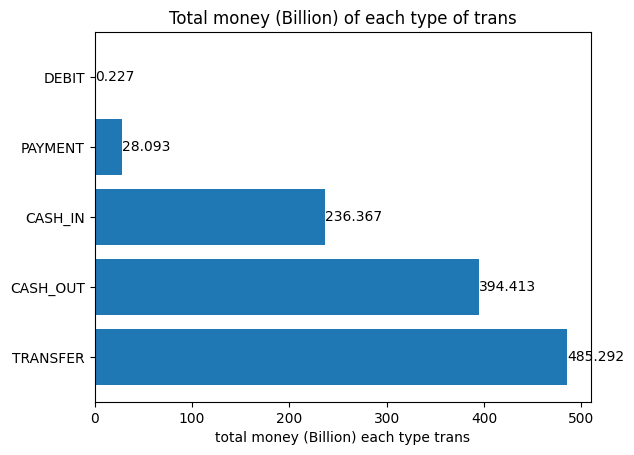

In [35]:
#plotting
import matplotlib as mpl
import matplotlib.pyplot as plt
labels = df_total_money.transactions
y_pos = np.arange(len(labels))
volume = df_total_money.money_total_in_Billion
#bar chart
fig, ax = plt.subplots()

hbars = ax.barh(y_pos, volume, align='center')
ax.set_yticks(y_pos, labels=labels)
ax.invert_yaxis()
ax.set_xlabel('total money (Billion) each type trans')
ax.set_title('Total money (Billion) of each type of trans')

#Label with specially formatted floats
ax.bar_label(ax.containers[0])
plt.show()

### Rules-based Model: Create a set of rules to identify fraud based on know cases

* This is an example of using WHERE clause in SQL to create set of rules to identify know fraud-bases cases, bases on some suspecting transations, we can flag out those as fraud
* in reality, rules are often much larger and more complicated

In [36]:
from pyspark.sql import functions as F
#set of rules to identify known Fraud-based
rules_fraud_based_df = original_fin_fraud_df.withColumn("label",
                  F.when(
                  (
                    (original_fin_fraud_df.oldbalanceOrg <= 56900) &\
                      (original_fin_fraud_df.type == 'TRANSFER') &\
                      (original_fin_fraud_df.newbalanceDest <= 105))|\
                (
                    (original_fin_fraud_df.oldbalanceOrg > 56900) &\
                      (original_fin_fraud_df.newbalanceOrig <= 12)) |\
                (
                    (original_fin_fraud_df.oldbalanceOrg > 56900) &\
                      (original_fin_fraud_df.newbalanceOrig > 12) &\
                        (original_fin_fraud_df.amount > 1160000))\
                      ,1).otherwise(0))

#Calcualte proportions
fraud_cases = rules_fraud_based_df.filter(rules_fraud_based_df.label == 1).count()
total_cases = rules_fraud_based_df.count()
fraud_pct = 1.*fraud_cases/total_cases

#provide a quick statistics
print("Based on these rules, we have flagged %s (%s) fraud cases out of a total of %s cases."\
     % (fraud_cases, fraud_pct, total_cases))

#Create temporary view to review data
rules_fraud_based_df.createOrReplaceTempView("financials_labeled")

23/02/07 20:34:09 WARN TaskSetManager: Stage 15 contains a task of very large size (64404 KiB). The maximum recommended task size is 1000 KiB.


23/02/07 20:34:15 WARN TaskSetManager: Stage 18 contains a task of very large size (64404 KiB). The maximum recommended task size is 1000 KiB.


Based on these rules, we have flagged 255640 (0.04017841706718302) fraud cases out of a total of 6362620 cases.


In [37]:
rules_fraud_based_df

DataFrame[step: bigint, type: string, amount: double, nameOrig: string, oldbalanceOrg: double, newbalanceOrig: double, nameDest: string, oldbalanceDest: double, newbalanceDest: double, orgDiff: double, destDiff: double, label: int]

In [38]:
%%sparksql
SELECT label, COUNT(1), SUM(amount) FROM financials_labeled GROUP BY label

23/02/07 20:34:22 WARN TaskSetManager: Stage 21 contains a task of very large size (64404 KiB). The maximum recommended task size is 1000 KiB.


label,count(1),sum(amount)
1,255640,129324296676.48
0,6106980,1015068648083.2874


#### plotting those bases_rule fraud cases

In [39]:
#fraud_base_rules dataset
based_rules_sql = 'SELECT label,\
                    COUNT(1) as Transactions,\
                    SUM(amount) as Total_amount FROM financials_labeled GROUP BY label'
collected_data3 = spark.sql(based_rules_sql).collect()

23/02/07 20:34:28 WARN TaskSetManager: Stage 24 contains a task of very large size (64404 KiB). The maximum recommended task size is 1000 KiB.


In [40]:
collected_data3

[Row(label=1, Transactions=255640, Total_amount=129324296676.48),
 Row(label=0, Transactions=6106980, Total_amount=1015068648083.2874)]

In [41]:
#convert to dataframe for plotting
df_based_rules = pd.DataFrame(collected_data3)
df_based_rules.rename(columns={0:'label', 1:'transactions', 2:'total_amount'}, inplace=True)
df_based_rules['flagged_label'] = np.where(df_based_rules['label']==1, 'fraud', 'normal')

In [42]:
df_based_rules

,label,transactions,total_amount,flagged_label
0,1,255640,1.293243e+11,fraud
1,0,6106980,1.015069e+12,normal


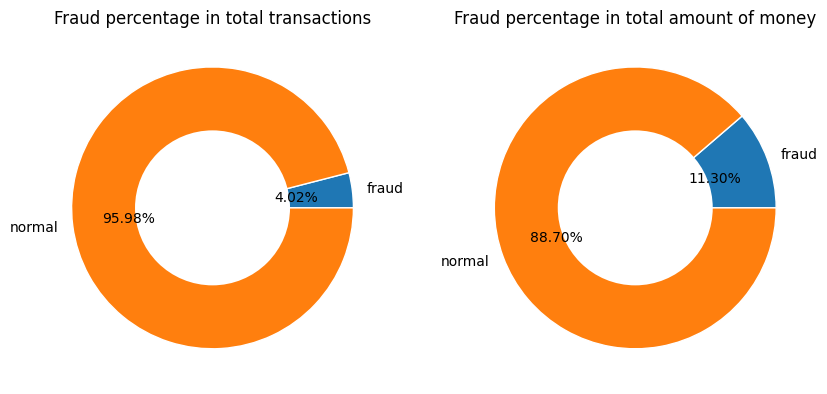

In [43]:
#plotting transactions
import matplotlib.pyplot as plt
labels = df_based_rules.flagged_label
volume = df_based_rules.transactions
amount = df_based_rules.total_amount
explode = (0.1, 0.0) #2 volumes to be exploded 

# double pie charts
# Make figure and axes
fig, axs = plt.subplots(1,2, figsize=(10, 5))
#first pie
axs[0].pie(volume, labels=labels, autopct='%1.2f%%',\
            wedgeprops= {"edgecolor":"white", 'linewidth': 1, 'antialiased': True})
axs[0].set_title("Fraud percentage in total transactions")

# Adding Circle in first Pie chart
centre_circle = plt.Circle((0, 0), 0.55, fc='white')
axs[0].add_artist(centre_circle)
#second pie
axs[1].pie(amount, labels=labels, autopct='%1.2f%%',\
             wedgeprops= {"edgecolor":"white", 'linewidth': 1, 'antialiased': True})
axs[1].set_title("Fraud percentage in total amount of money")

# Adding Circle in second Pie chart
centre_circle = plt.Circle((0, 0), 0.55, fc='white')
axs[1].add_artist(centre_circle)

plt.show()

Based on this based rule, 4% of the trans are fraudulent, it takes into account of the 11% of the total amount.

#### Top origination/Dest difference pairs in Total dest difference over 1M

In [44]:
%%sparksql
SELECT nameOrig, nameDest, label, TotalOrgDiff, TotalDestDiff
FROM (
    SELECT nameOrig, nameDest, label, SUM(OrgDiff) as TotalOrgDiff, SUM(destDiff) as TotalDestDiff
    FROM financials_labeled
    GROUP BY nameOrig, nameDest, label) a
WHERE TotalDestDiff >= 1000000
limit 100

23/02/07 20:34:35 WARN TaskSetManager: Stage 27 contains a task of very large size (64404 KiB). The maximum recommended task size is 1000 KiB.


only showing top 20 row(s)


nameOrig,nameDest,label,TotalOrgDiff,TotalDestDiff
C752686443,C1816757085,0,-51178.0,1037297.459999999
C1034899044,C306206744,0,0.0,2308448.1800000006
C1337803451,C1778801068,0,0.0,3155647.91
C1570013189,C1945802665,1,-63916.0,1179067.2799999998
C1379731404,C413177525,0,0.0,2375262.37
C608080514,C2006081398,1,-101396.29,3208776.46
C1567963311,C1141049797,0,136177.75999999978,1243657.54
C582291919,C461640598,0,0.0,3381134.63
C689413511,C1988852187,0,0.0,1161908.05
C122861681,C1754722089,0,-22291.0,1512938.6399999997


#### Plotting Orig/Dest difference pairs

In [45]:
#collect data to convert to dataframe
orig_dest_diff_sql = "\
SELECT a.nameOrig, a.nameDest, a.label, a.TotalOrgDiff, a.TotalDestDiff \
FROM (SELECT nameOrig, nameDest, label, SUM(OrgDiff) as TotalOrgDiff, SUM(destDiff) as TotalDestDiff \
        FROM financials_labeled GROUP BY nameOrig, nameDest, label) as a \
WHERE TotalDestDiff >= 1000000 LIMIT 100"

collected_data4 = spark.sql(orig_dest_diff_sql).collect()

23/02/07 20:34:46 WARN TaskSetManager: Stage 30 contains a task of very large size (64404 KiB). The maximum recommended task size is 1000 KiB.


In [46]:
collected_data4

[Row(nameOrig='C752686443', nameDest='C1816757085', label=0, TotalOrgDiff=-51178.0, TotalDestDiff=1037297.459999999),
 Row(nameOrig='C1034899044', nameDest='C306206744', label=0, TotalOrgDiff=0.0, TotalDestDiff=2308448.1800000006),
 Row(nameOrig='C1337803451', nameDest='C1778801068', label=0, TotalOrgDiff=0.0, TotalDestDiff=3155647.91),
 Row(nameOrig='C1570013189', nameDest='C1945802665', label=1, TotalOrgDiff=-63916.0, TotalDestDiff=1179067.2799999998),
 Row(nameOrig='C1379731404', nameDest='C413177525', label=0, TotalOrgDiff=0.0, TotalDestDiff=2375262.37),
 Row(nameOrig='C608080514', nameDest='C2006081398', label=1, TotalOrgDiff=-101396.29, TotalDestDiff=3208776.46),
 Row(nameOrig='C1567963311', nameDest='C1141049797', label=0, TotalOrgDiff=136177.75999999978, TotalDestDiff=1243657.54),
 Row(nameOrig='C582291919', nameDest='C461640598', label=0, TotalOrgDiff=0.0, TotalDestDiff=3381134.63),
 Row(nameOrig='C689413511', nameDest='C1988852187', label=0, TotalOrgDiff=0.0, TotalDestDiff=11

In [47]:
pd.DataFrame(collected_data4)

,0,1,2,3,4
0,C752686443,C1816757085,0,-51178.00,1037297.46
1,C1034899044,C306206744,0,0.00,2308448.18
2,C1337803451,C1778801068,0,0.00,3155647.91
3,C1570013189,C1945802665,1,-63916.00,1179067.28
4,C1379731404,C413177525,0,0.00,2375262.37
...,...,...,...,...,...
95,C235819446,C311573688,1,-1175734.28,2214979.54
96,C752293219,C1523549102,1,-221344.00,1974939.90
97,C2117929123,C931773845,0,0.00,1195544.19
98,C788474781,C210970463,0,-21308.00,1034059.37


In [48]:
#convert to dataframe for plotting
df_top_diff_Org_Dest = pd.DataFrame(collected_data4)
df_top_diff_Org_Dest.rename(columns={0:'nameOrig',
                                     1:'nameDest', 
                                     2:'label',
                                    3:'TotalOrgDiff',
                                    4:'TotalDestDiff'}, inplace=True)
df_top_diff_Org_Dest['flagged_label'] = np.where(df_top_diff_Org_Dest['label']==1, 'fraud', 'normal')
df_top_diff_Org_Dest['name'] = df_top_diff_Org_Dest.nameOrig + df_top_diff_Org_Dest.nameDest

In [49]:
df_top_diff_Org_Dest

,nameOrig,nameDest,label,TotalOrgDiff,TotalDestDiff,flagged_label,name
0,C752686443,C1816757085,0,-51178.00,1037297.46,normal,C752686443C1816757085
1,C1034899044,C306206744,0,0.00,2308448.18,normal,C1034899044C306206744
2,C1337803451,C1778801068,0,0.00,3155647.91,normal,C1337803451C1778801068
3,C1570013189,C1945802665,1,-63916.00,1179067.28,fraud,C1570013189C1945802665
4,C1379731404,C413177525,0,0.00,2375262.37,normal,C1379731404C413177525
...,...,...,...,...,...,...,...
95,C235819446,C311573688,1,-1175734.28,2214979.54,fraud,C235819446C311573688
96,C752293219,C1523549102,1,-221344.00,1974939.90,fraud,C752293219C1523549102
97,C2117929123,C931773845,0,0.00,1195544.19,normal,C2117929123C931773845
98,C788474781,C210970463,0,-21308.00,1034059.37,normal,C788474781C210970463


In [50]:
def number_format_M(number):
    #function format number to Million
    units = 'B'
    k = 1000000.0
    return '%.3f' % (number / k)

In [51]:
#format to Million column TotalOrgDiff, TotalDestDiff
df_top_diff_Org_Dest['TotalOrgDiff'] = \
            df_top_diff_Org_Dest['TotalOrgDiff'].apply(lambda x: number_format_M(x))
df_top_diff_Org_Dest['TotalDestDiff'] = \
            df_top_diff_Org_Dest['TotalDestDiff'].apply(lambda x: number_format_M(x))

In [52]:
df_top_diff_Org_Dest.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   nameOrig       100 non-null    object
 1   nameDest       100 non-null    object
 2   label          100 non-null    int64 
 3   TotalOrgDiff   100 non-null    object
 4   TotalDestDiff  100 non-null    object
 5   flagged_label  100 non-null    object
 6   name           100 non-null    object
dtypes: int64(1), object(6)
memory usage: 5.6+ KB


In [53]:
#for plotting easier
df_top_diff_Org_Dest = df_top_diff_Org_Dest.set_index('name')
df_top_diff_Org_Dest = df_top_diff_Org_Dest[['TotalOrgDiff', 'TotalDestDiff']]
#convert orgdiff and destdiff to int
df_top_diff_Org_Dest['TotalOrgDiff'] = \
            df_top_diff_Org_Dest['TotalOrgDiff'].apply(lambda x: abs(float(x)))
df_top_diff_Org_Dest['TotalDestDiff'] = \
            df_top_diff_Org_Dest['TotalDestDiff'].apply(lambda x: abs(float(x)))
#convert to ab
df_top_diff_Org_Dest.head(5)

,TotalOrgDiff,TotalDestDiff
name,,
C752686443C1816757085,0.051,1.037
C1034899044C306206744,0.000,2.308
C1337803451C1778801068,0.000,3.156
C1570013189C1945802665,0.064,1.179
C1379731404C413177525,0.000,2.375


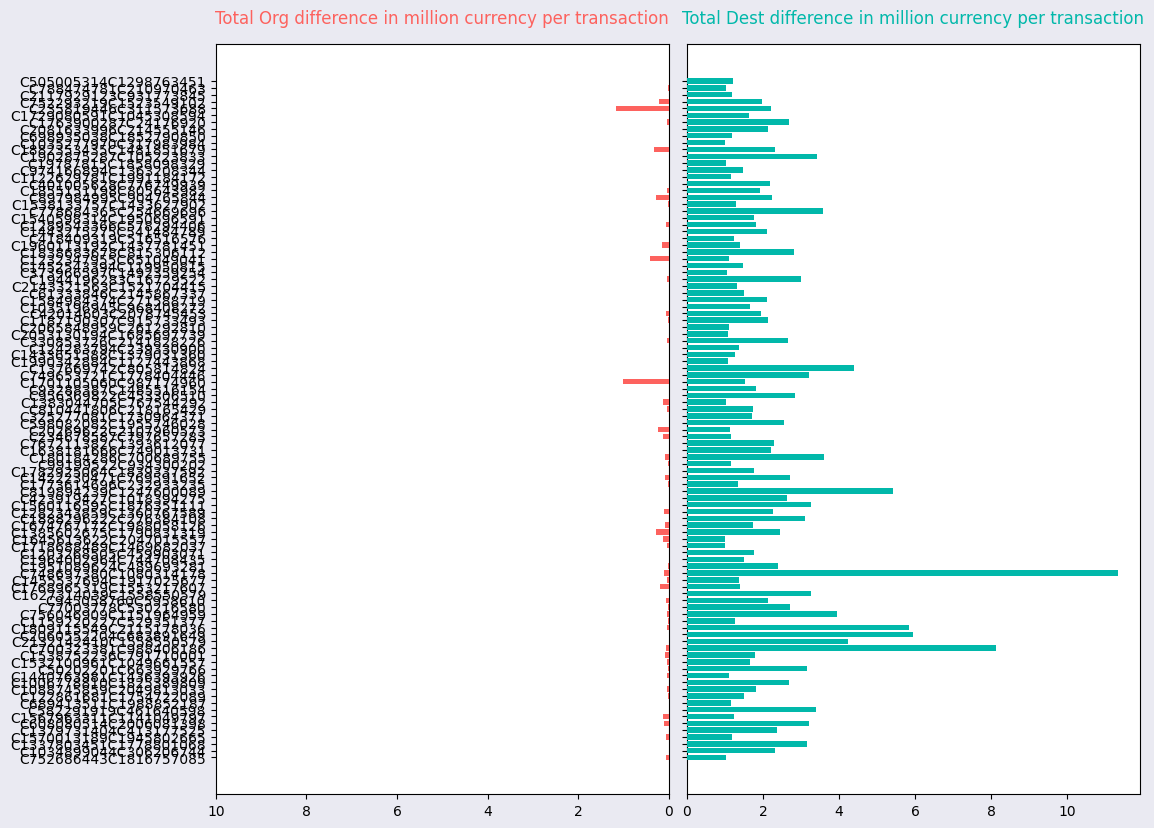

In [62]:
#library
import matplotlib.pyplot as plt

#Create lists of variables
font_color = '#525252'
hfont = {'fontname':"Calibri"}
facecolor = '#eaeaf2'
color_red = '#fd625e'
color_blue = '#01b8aa'
index = df_top_diff_Org_Dest.index
col0 = df_top_diff_Org_Dest['TotalOrgDiff']
col1 = df_top_diff_Org_Dest['TotalDestDiff']
title0 = 'Total Org difference in million currency per transaction'
title1 = "Total Dest difference in million currency per transaction"

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,10), facecolor=facecolor, sharey=True)
fig.tight_layout()

#plot bars
ax1.barh(index, col0, align='center', color=color_red, zorder=10)
ax1.set_title(title0, fontsize=12, pad=15, color=color_red, **hfont)
ax2.barh(index, col1, align='center', color=color_blue, zorder=10)
ax2.set_title(title1, fontsize=12, pad=15, color=color_blue, **hfont)

#invert ax1 to back to back with ax2
ax1.invert_xaxis()
#set ticks
ax1.set(yticks=df_top_diff_Org_Dest.index, yticklabels=df_top_diff_Org_Dest.index)
ax1.yaxis.tick_left()
ax1.tick_params(axis='y', colors='black')
ax1.set_xticks([0,2,4,6,8,10])
ax2.set_xticks([0,2,4,6,8,10])
#ax1.set_yticks(color_blue)
#adjust subplots
plt.subplots_adjust(wspace=0.04, top=0.85, bottom=0.1, left=0.18, right=0.95)

plt.show()

#### What type of transactions are associated with fraud?

In [65]:
%%sparksql
select type, label, count(1) as Transactions from financials_labeled group by type, label

23/02/07 20:41:19 WARN TaskSetManager: Stage 37 contains a task of very large size (64404 KiB). The maximum recommended task size is 1000 KiB.


type,label,Transactions
PAYMENT,0,2150909
CASH_OUT,0,2052790
DEBIT,1,31
TRANSFER,1,70248
CASH_OUT,1,184710
PAYMENT,1,586
DEBIT,0,41401
CASH_IN,0,1399219
TRANSFER,0,462661
CASH_IN,1,65


In [67]:
#collect data to convert to dataframe
fraud_in_type_trans_sql = "select type,\
                                    label,\
                                    count(1) as transactions\
                            from financials_labeled\
                            group by type, label;"

###
collected_data5 = spark.sql(fraud_in_type_trans_sql).collect()

23/02/07 20:47:21 WARN TaskSetManager: Stage 40 contains a task of very large size (64404 KiB). The maximum recommended task size is 1000 KiB.


In [68]:
collected_data5

[Row(type='PAYMENT', label=0, transactions=2150909),
 Row(type='CASH_OUT', label=0, transactions=2052790),
 Row(type='DEBIT', label=1, transactions=31),
 Row(type='TRANSFER', label=1, transactions=70248),
 Row(type='CASH_OUT', label=1, transactions=184710),
 Row(type='PAYMENT', label=1, transactions=586),
 Row(type='DEBIT', label=0, transactions=41401),
 Row(type='CASH_IN', label=0, transactions=1399219),
 Row(type='TRANSFER', label=0, transactions=462661),
 Row(type='CASH_IN', label=1, transactions=65)]

In [89]:
df_fraud_in_type_trans = pd.DataFrame(collected_data5)
df_fraud_in_type_trans = df_fraud_in_type_trans.rename(columns={0:'type', 1:'label', 2:'sum_trans'})
df_fraud_in_type_trans = df_fraud_in_type_trans[df_fraud_in_type_trans['label'] == 1]

In [90]:
df_fraud_in_type_trans

,type,label,sum_trans
2,DEBIT,1,31
3,TRANSFER,1,70248
4,CASH_OUT,1,184710
5,PAYMENT,1,586
9,CASH_IN,1,65


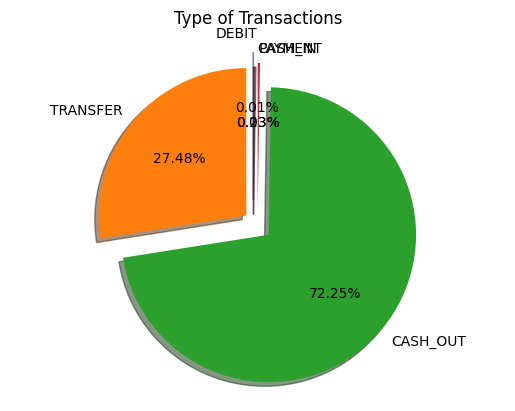

In [91]:
#plotting
import matplotlib.pyplot as plt
labels = df_fraud_in_type_trans.type
volume = df_fraud_in_type_trans.sum_trans
explode = (0.2, 0.1, 0.1, 0.1, 0.1) # 5 volume to be exploded
#pie
plt.pie(volume, labels=labels, startangle=90,
        shadow=True, explode=explode, autopct='%1.2f%%')
#title
plt.title('Type of Transactions')
plt.axis('equal')
plt.show()